In [2]:
import numpy as np
import matplotlib.pyplot as plt
from img_preprocessing import get_full_frame
from keras.optimizers import Adam, SGD

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
val_den = np.load("./data/mall_processed/val-densities-small-blur.npy")
train_den = np.load("./data/mall_processed/train-densities-small-blur.npy")
val_imgs = np.load("./data/mall_processed/val-imgs.npy")
train_imgs = np.load("./data/mall_processed/train-imgs.npy")

In [4]:
print(train_den.shape)

(750, 120, 160, 1)


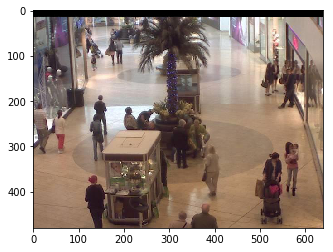

In [5]:
plt.imshow(train_imgs[0])

29000.000000000004

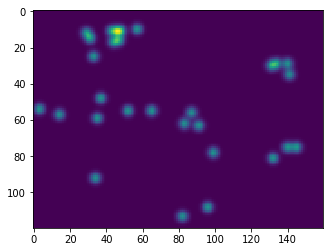

In [6]:
plt.imshow(train_den[0].reshape(train_den.shape[1], train_den.shape[2]))
np.sum(train_den[0])

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from loss import den_loss
from loss import den_loss_abs as abs_diff
import keras.losses
keras.losses.den_loss_sqr = den_loss

In [12]:
input_img = Input(shape=(480, 640, 3))
x = Conv2D(20, (7, 7), activation="relu", padding="same")(input_img)
#x = BatchNormalization()(x)
x = Conv2D(20, (7, 7), activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(40, (5, 5), activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
x = Conv2D(40, (5, 5), activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(20, (5, 5), activation="relu", padding="same")(x)
#x = Conv2D(20, (5, 5), activation="relu", padding="same")(x)
x = Conv2D(10, (5, 5), activation="relu", padding="same")(x)

x = Conv2D(1, (1, 1), activation="relu", padding="same")(x)

In [20]:
class AccuracyStopper(keras.callbacks.Callback):
    def __init__(self, look_back=5, target_slope=0.1):
        self.look_back = look_back
        self.target_slope = target_slope
    
    def on_train_begin(self, logs={}):
        self.acc = []
        self.epoch_count = 0

    def on_epoch_end(self, batch, logs={}):
        self.epoch_count += 1
        self.acc.append(logs.get('val_den_loss_abs'))
        if self.epoch_count >= self.look_back:
            acc_slope = 0
            acc_slope = (self.acc[self.epoch_count-1] - self.acc[self.epoch_count-self.look_back])/self.look_back
            print(" - abs_diff_slope: {}".format(acc_slope))
            if acc_slope < self.target_slope:
                print("abs_diff_slope is past the target_slope. Stopping training.")
                self.model.stop_training = True
        
acc_callback = AccuracyStopper(look_back=4, target_slope=0.1)
filepath="./large_column/checkpoints/large_column_weights-1.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')
early_stopper = EarlyStopping(patience=0, monitor="val_loss")

In [21]:
callbacks_list = [early_stopper, checkpoint]
m = Model(input_img, x)
optimizer = Adam(lr=0.0000001)
#optimizer = SGD(lr=0.001)
m.compile(optimizer=optimizer, loss=abs_diff)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 480, 640, 20)      2960      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 480, 640, 20)      19620     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 240, 320, 20)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 240, 320, 40)      20040     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 240, 320, 40)      40040     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 120, 160, 40)      0         
__________

In [22]:
#m.load_weights("./large_column/checkpoints/large_column_weights.h5")

In [ ]:
history = m.fit(train_imgs, train_den, epochs=1000, batch_size=10, validation_data=(val_imgs, val_den), callbacks=callbacks_list)

Train on 750 samples, validate on 250 samples
Epoch 1/1000
740/750 [============================>.] - ETA: 0s - loss: 157755.7185
Epoch 00001: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 51s 68ms/step - loss: 157834.3756 - val_loss: 180019.6231
Epoch 2/1000
740/750 [============================>.] - ETA: 0s - loss: 157571.3628
Epoch 00002: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 48s 64ms/step - loss: 157559.2300 - val_loss: 179770.5150
Epoch 3/1000
740/750 [============================>.] - ETA: 0s - loss: 157206.2080
Epoch 00003: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 48s 64ms/step - loss: 157287.8894 - val_loss: 179524.6681
Epoch 4/1000
740/750 [============================>.] - ETA: 0s - loss: 156975.6923
Epoch 00004: saving model to ./large_column/checkpoints/large_column_

Epoch 32/1000
740/750 [============================>.] - ETA: 0s - loss: 147658.0703
Epoch 00032: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 48s 63ms/step - loss: 147362.9730 - val_loss: 170746.6862
Epoch 33/1000
740/750 [============================>.] - ETA: 0s - loss: 147009.9198
Epoch 00033: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 47s 63ms/step - loss: 147322.4252 - val_loss: 170716.6969
Epoch 34/1000
740/750 [============================>.] - ETA: 0s - loss: 147095.6162
Epoch 00034: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 47s 63ms/step - loss: 147286.7684 - val_loss: 170690.1353
Epoch 35/1000
740/750 [============================>.] - ETA: 0s - loss: 147388.0795
Epoch 00035: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [====================

Epoch 67/1000
740/750 [============================>.] - ETA: 0s - loss: 146768.1545
Epoch 00067: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 47s 62ms/step - loss: 146918.9216 - val_loss: 170385.0200
Epoch 68/1000
740/750 [============================>.] - ETA: 0s - loss: 147107.4015
Epoch 00068: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 47s 63ms/step - loss: 146913.6068 - val_loss: 170379.3525
Epoch 69/1000
740/750 [============================>.] - ETA: 0s - loss: 146913.1171
Epoch 00069: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [==============================] - 47s 62ms/step - loss: 146908.4630 - val_loss: 170373.8544
Epoch 70/1000
740/750 [============================>.] - ETA: 0s - loss: 146921.5934
Epoch 00070: saving model to ./large_column/checkpoints/large_column_weights-1.h5
750/750 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



670/750 [=========================>....] - ETA: 4s - loss: 147569.4136

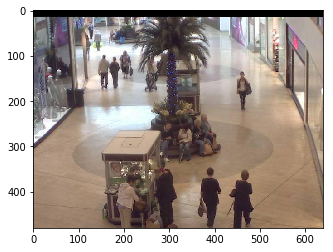

In [9]:
blur = True
sample_frame = 500
frame = get_full_frame(sample_frame, blur=blur, scale_down=1)
img = frame["image"]
num_heads = len(frame["locations"])
ground_truth = frame["loc_img"].reshape((480, 640))

img_in = img.reshape((1, 480, 640, 3))
out = m.predict(img_in)
img_out = out.reshape((120, 160))
plt.imshow(img_in[0])

25.999999999999996
20.08834


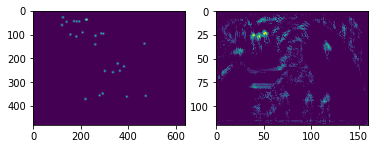

In [10]:
print(np.sum(ground_truth))
print(np.sum(img_out))
#plt.imshow(ground_truth)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(ground_truth)
fig.add_subplot(1, 2, 2)
plt.imshow(img_out)

In [ ]:
#m.save("large_column_v2-small-V2-1.h5")

In [5]:
m = load_model("./large_column/checkpoints/large_column_weights.h5")

In [6]:
print(history.history.keys())

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
total_error = 0
total_sum = 0
average_error = 0
for i in range(2000):
    frame = get_full_frame(i, blur=blur, scale_down=1)
    num_heads = len(frame["locations"])
    img = frame["image"]
    img_in = img.reshape((1, 480, 640, 3))
    out = m.predict(img_in)
    diff = (np.sum(out)) - num_heads
    total_error += abs(diff)
    total_sum += diff
    average_error = total_error/i
    average_sum = total_sum/i
    print("Average Error: {}, Average Sum: {}".format(average_error, average_sum))

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Average Error: inf, Average Sum: -inf
Average Error: 16.988319396972656, Average Sum: -16.988319396972656
Average Error: 15.323270797729492, Average Sum: -15.323270797729492
Average Error: 13.519753138224283, Average Sum: -13.519753138224283
Average Error: 11.494036674499512, Average Sum: -11.494036674499512
Average Error: 10.356661224365235, Average Sum: -10.356661224365235
Average Error: 9.756468772888184, Average Sum: -9.756468772888184
Average Error: 9.084111894880023, Average Sum: -9.084111894880023
Average Error: 8.81112003326416, Average Sum: -8.81112003326416
Average Error: 8.776599884033203, Average Sum: -8.776599884033203
Average Error: 9.260422134399414, Average Sum: -9.260422134399414
Average Error: 9.736333500255238, Average Sum: -9.736333500255238
Average Error: 10.446762720743815, Average Sum: -10.446762720743815
Average Error: 10.991605905386118, Average Sum: -10.991605905386118
Average Error: 11.46477576664516, Average Sum: -11.46477576664516
Average Error: 11.79301910

Average Error: 5.763198539733887, Average Sum: -4.7442661514282225
Average Error: 5.767199766068232, Average Sum: -4.75635414274912
Average Error: 5.751726728724682, Average Sum: -4.748840519762415
Average Error: 5.736596487462521, Average Sum: -4.7415453270077705
Average Error: 5.733966213788173, Average Sum: -4.746628628220669
Average Error: 5.736388697991004, Average Sum: -4.756646016927866
Average Error: 5.74505752825555, Average Sum: -4.772793798956252
Average Error: 5.735216408064871, Average Sum: -4.770318313078447
Average Error: 5.736670422374754, Average Sum: -4.779027200282965
Average Error: 5.732434351052811, Average Sum: -4.781937720170662
Average Error: 5.7095125057079175, Average Sum: -4.766056590610081
Average Error: 5.708411812782288, Average Sum: -4.771893073530758
Average Error: 5.70006265431425, Average Sum: -4.770379818268936
Average Error: 5.7092406853385596, Average Sum: -4.786294681438501
Average Error: 5.709439991189422, Average Sum: -4.793133886597997
Average E

Average Error: 4.655145538330078, Average Sum: -4.061396842956543
Average Error: 4.655677290076754, Average Sum: -4.064294127354109
Average Error: 4.6530480271294, Average Sum: -4.064011622988988
Average Error: 4.651552901437631, Average Sum: -4.064844704428209
Average Error: 4.6392153454577825, Average Sum: -4.054817023239736
Average Error: 4.62580301247391, Average Sum: -4.043696448382209
Average Error: 4.6085268296301365, Average Sum: -4.027107398957014
Average Error: 4.591655282194976, Average Sum: -4.012498183936924
Average Error: 4.576070648755214, Average Sum: -3.9947333853374154
Average Error: 4.567145472787982, Average Sum: -3.9880527547887854
Average Error: 4.556877411328829, Average Sum: -3.9800119730142445
Average Error: 4.5570575487568, Average Sum: -3.9824023228495515
Average Error: 4.544712179489718, Average Sum: -3.972250294139367
Average Error: 4.540793556677524, Average Sum: -3.9705083324882016
Average Error: 4.547977964083354, Average Sum: -3.979852911197778
Average 

Average Error: 5.348727218668404, Average Sum: -4.930577994025354
Average Error: 5.374119031996954, Average Sum: -4.957076022233912
Average Error: 5.406709751541822, Average Sum: -4.990767119113248
Average Error: 5.454796936637477, Average Sum: -5.039948890083714
Average Error: 5.491426472901672, Average Sum: -5.077667266365111
Average Error: 5.523461486656628, Average Sum: -5.110785419404195
Average Error: 5.552883048592909, Average Sum: -5.141284464544789
Average Error: 5.582661390304565, Average Sum: -5.172134677569072
Average Error: 5.619633156912667, Average Sum: -5.210172747327135
Average Error: 5.664343586857455, Average Sum: -5.255943955535098
Average Error: 5.705147780189218, Average Sum: -5.297803445071829
Average Error: 5.738514079261072, Average Sum: -5.33221960067749
Average Error: 5.768558144262946, Average Sum: -5.363308124493204
Average Error: 5.801482024559608, Average Sum: -5.39727110740466
Average Error: 5.837641533073562, Average Sum: -5.434464403430519
Average Erro

Average Error: 7.679355122783397, Average Sum: -7.3671922362676945
Average Error: 7.683915070394282, Average Sum: -7.372369106579204
Average Error: 7.679941933535965, Average Sum: -7.36901045880139
Average Error: 7.681111515976313, Average Sum: -7.370792111073892
Average Error: 7.677081008791221, Average Sum: -7.367371268731437
Average Error: 7.677134756948433, Average Sum: -7.368032290888768
Average Error: 7.675861186943876, Average Sum: -7.3673636180780635
Average Error: 7.679424621164799, Average Sum: -7.371529586613178
Average Error: 7.6821571298045255, Average Sum: -7.374862280505442
Average Error: 7.689001892327335, Average Sum: -7.382304892929612
Average Error: 7.6894821463279355, Average Sum: -7.383380675084383
Average Error: 7.6947578681531805, Average Sum: -7.389249616815138
Average Error: 7.6959887491665215, Average Sum: -7.391071422879424
Average Error: 7.695769100115566, Average Sum: -7.391440417315509
Average Error: 7.6960580307624245, Average Sum: -7.392315723073735
Aver

Average Error: 7.962154974256243, Average Sum: -7.711929168398418
Average Error: 7.969245035561443, Average Sum: -7.719415784071062
Average Error: 7.978874189944207, Average Sum: -7.729440237902388
Average Error: 7.981573169641962, Average Sum: -7.732533268077302
Average Error: 7.983434353717118, Average Sum: -7.734787259568176
Average Error: 7.982225164278286, Average Sum: -7.733969640356349
Average Error: 7.98537441019742, Average Sum: -7.737509225149575
Average Error: 7.989248058672415, Average Sum: -7.741771986944896
Average Error: 7.998802939926195, Average Sum: -7.75171476172803
Average Error: 8.004668573072072, Average Sum: -7.757967074339006
Average Error: 8.0111687079072, Average Sum: -7.7648526802659035
Average Error: 8.016106052071368, Average Sum: -7.770174292803927
Average Error: 8.020104213667064, Average Sum: -7.774555525675741
Average Error: 8.025868605677484, Average Sum: -7.780701797449756
Average Error: 8.02980863825875, Average Sum: -7.785022523832617
Average Error:

Average Error: 8.675264694002777, Average Sum: -8.467567384792725
Average Error: 8.681289849783244, Average Sum: -8.473865826506364
Average Error: 8.686951103410959, Average Sum: -8.479799647838778
Average Error: 8.688584854596556, Average Sum: -8.481705251328275
Average Error: 8.688178552400082, Average Sum: -8.481570088847748
Average Error: 8.689708096818775, Average Sum: -8.483370063192558
Average Error: 8.688178468841354, Average Sum: -8.48211015813491
Average Error: 8.687265267882584, Average Sum: -8.481465975858525
Average Error: 8.684315318389853, Average Sum: -8.478784343565303
Average Error: 8.680038654555878, Average Sum: -8.47477529818813
Average Error: 8.675357489964123, Average Sum: -8.470361056036385
Average Error: 8.673187190216858, Average Sum: -8.46845698542409
Average Error: 8.673964619172686, Average Sum: -8.469499952907537
Average Error: 8.675812717546453, Average Sum: -8.471612901885274
Average Error: 8.676338801562864, Average Sum: -8.472403151251829
Average Error

Average Error: 8.923544578422788, Average Sum: -8.745216232619134
Average Error: 8.925829725750422, Average Sum: -8.747702880902478
Average Error: 8.928146423658452, Average Sum: -8.75022062491079
Average Error: 8.93215232019091, Average Sum: -8.754427114226504
Average Error: 8.935635604299941, Average Sum: -8.75811053933324
Average Error: 8.942018683769303, Average Sum: -8.764693309539348
Average Error: 8.944281630569629, Average Sum: -8.767155498333192
Average Error: 8.948661334319281, Average Sum: -8.77173399684405
Average Error: 8.955201654690798, Average Sum: -8.778472666248613
Average Error: 8.964220708054631, Average Sum: -8.787689624414732
Average Error: 8.971874383205268, Average Sum: -8.795540761627606
Average Error: 8.978470936567424, Average Sum: -8.802334335795994
Average Error: 8.98685781551259, Average Sum: -8.810917795768805
Average Error: 8.993570373475618, Average Sum: -8.817826496451728
Average Error: 9.001050423407607, Average Sum: -8.825502252260137
Average Error: 

Average Error: 9.387485461785786, Average Sum: -9.231866253799183
Average Error: 9.387474433439959, Average Sum: -9.23200869607267
Average Error: 9.387218709297368, Average Sum: -9.231906140144236
Average Error: 9.385239412465433, Average Sum: -9.230079710014223
Average Error: 9.384382130708197, Average Sum: -9.229374994336094
Average Error: 9.384789913717094, Average Sum: -9.229935043687203
Average Error: 9.385197323133713, Average Sum: -9.230494420591585
Average Error: 9.38709500911189, Average Sum: -9.232543776082057
Average Error: 9.38988602943682, Average Sum: -9.235486168819357
Average Error: 9.390842940709362, Average Sum: -9.236594156276457
Average Error: 9.392783239556664, Average Sum: -9.238685235949205
Average Error: 9.396801424212754, Average Sum: -9.242853906936944
Average Error: 9.400444081934486, Average Sum: -9.246646757358459
Average Error: 9.406512858110096, Average Sum: -9.252865433460556
Average Error: 9.412346084022708, Average Sum: -9.258848267381588
Average Error

Average Error: 9.48645653950145, Average Sum: -9.34841603364293
Average Error: 9.493117010395254, Average Sum: -9.355197274883066
Average Error: 9.501900110211405, Average Sum: -9.364100933908583
Average Error: 9.509239087667007, Average Sum: -9.371560259989776
Average Error: 9.51471232618961, Average Sum: -9.377153637105465
Average Error: 9.52332270571535, Average Sum: -9.38588394574113
Average Error: 9.533462746218106, Average Sum: -9.39614370641808
Average Error: 9.543863161218177, Average Sum: -9.406663633202138
Average Error: 9.553603866411292, Average Sum: -9.416523642332658
Average Error: 9.561744717283936, Average Sum: -9.424783589837864
Average Error: 9.569996826350689, Average Sum: -9.43315458877219
Average Error: 9.579981458156086, Average Sum: -9.443257904218159
Average Error: 9.58932251740163, Average Sum: -9.452717441413391
Average Error: 9.60053891846628, Average Sum: -9.464052115271102
Average Error: 9.606661097813642, Average Sum: -9.470292362787319
Average Error: 9.61

Average Error: 9.621742795750016, Average Sum: -9.497321124328998
Average Error: 9.626722726160043, Average Sum: -9.502399179085572
Average Error: 9.629488952522488, Average Sum: -9.505263375146264
Average Error: 9.633708986147182, Average Sum: -9.509581224186213
Average Error: 9.63572671636646, Average Sum: -9.51169661590192
Average Error: 9.640455131260854, Average Sum: -9.51652253873693
Average Error: 9.64405318647506, Average Sum: -9.520217948697818
Average Error: 9.64812947592144, Average Sum: -9.524391440057679
Average Error: 9.652642308403465, Average Sum: -9.529001321979598
Average Error: 9.656638621536542, Average Sum: -9.53309453243746
Average Error: 9.657191119720531, Average Sum: -9.53374377618848
Average Error: 9.660983358004097, Average Sum: -9.537632608637564
Average Error: 9.664761916094221, Average Sum: -9.541507609846818
Average Error: 9.666117016226053, Average Sum: -9.542959002405405
Average Error: 9.668220764952279, Average Sum: -9.545158893218924
Average Error: 9.

Average Error: 9.527273330442544, Average Sum: -9.414349077082637
Average Error: 9.52744538696988, Average Sum: -9.414601967005364
Average Error: 9.5275376214831, Average Sum: -9.414774919272492
Average Error: 9.529397607957405, Average Sum: -9.416715508107204
Average Error: 9.531229329109191, Average Sum: -9.418627716473171
Average Error: 9.53153567072496, Average Sum: -9.419014430403454
Average Error: 9.533220376845943, Average Sum: -9.420779394185152
Average Error: 9.534741356129826, Average Sum: -9.422380516721109
Average Error: 9.541057746974152, Average Sum: -9.428776936653334
Average Error: 9.548233032226562, Average Sum: -9.436032137073232
Average Error: 9.555592928977305, Average Sum: -9.443471835314126
Average Error: 9.561617213441027, Average Sum: -9.449575807833044
Average Error: 9.56749376925555, Average Sum: -9.455531938509507
Average Error: 9.572094348070891, Average Sum: -9.460211979234531
Average Error: 9.576166719747773, Average Sum: -9.464363700109171
Average Error: 

Average Error: 9.988164269085544, Average Sum: -9.88452044417402
Average Error: 9.987399288608586, Average Sum: -9.883823560822496
Average Error: 9.984818920679023, Average Sum: -9.881311200593384
Average Error: 9.982048887593226, Average Sum: -9.878609085959086
Average Error: 9.980087527290719, Average Sum: -9.8767155550347
Average Error: 9.977441849589816, Average Sum: -9.87413761781365
Average Error: 9.975589223210923, Average Sum: -9.872352643190995
Average Error: 9.973370420371051, Average Sum: -9.870201403557942
Average Error: 9.971174668610837, Average Sum: -9.868073126628868
Average Error: 9.970227465286754, Average Sum: -9.867193309933532
Average Error: 9.969947267404029, Average Sum: -9.866980410649992
Average Error: 9.970018701204744, Average Sum: -9.867119055192713
Average Error: 9.971741100268977, Average Sum: -9.868908577313706
Average Error: 9.97200476548196, Average Sum: -9.869239278069687
Average Error: 9.976052596126395, Average Sum: -9.873354056914389
Average Error: 

Average Error: 10.314028209208862, Average Sum: -10.218255270150278
Average Error: 10.3187516159771, Average Sum: -10.223036826851155
Average Error: 10.321313883494405, Average Sum: -10.225657173730795
Average Error: 10.325895006400733, Average Sum: -10.230296305557538
Average Error: 10.331633222175366, Average Sum: -10.236092459938742
Average Error: 10.337359501765324, Average Sum: -10.241876607949195
Average Error: 10.341055504057655, Average Sum: -10.2456304086034
Average Error: 10.340979718613898, Average Sum: -10.245612351590045
Average Error: 10.34320853324438, Average Sum: -10.247898824846297
Average Error: 10.345440445637776, Average Sum: -10.250188326187365
Average Error: 10.345313318685633, Average Sum: -10.250118718631025
Average Error: 10.34583026584402, Average Sum: -10.25069311575927
Average Error: 10.347233803338394, Average Sum: -10.252154033923178
Average Error: 10.346138362643085, Average Sum: -10.251115904722392
Average Error: 10.347764879249665, Average Sum: -10.252

Average Error: 10.313337317433888, Average Sum: -10.224324184915293
Average Error: 10.317452600793429, Average Sum: -10.228489701419598
Average Error: 10.320730799950924, Average Sum: -10.23181807705728
Average Error: 10.32290372020631, Average Sum: -10.234041117224107
Average Error: 10.324495771166305, Average Sum: -10.235683231622401
Average Error: 10.32529853485726, Average Sum: -10.23653600237391
Average Error: 10.326277574529524, Average Sum: -10.237564992824161
Average Error: 10.32772764607141, Average Sum: -10.239064958956432
Average Error: 10.329044610077641, Average Sum: -10.240431761460199
Average Error: 10.332017150621736, Average Sum: -10.243454084503517
Average Error: 10.334816097878527, Average Sum: -10.246302758355545
Average Error: 10.33629905495178, Average Sum: -10.247835386214165
Average Error: 10.339006211071688, Average Sum: -10.250592157403473
Average Error: 10.342486577183676, Average Sum: -10.254122082962583
Average Error: 10.345676086596749, Average Sum: -10.25

Average Error: 10.454784397334489, Average Sum: -10.371639746653882
Average Error: 10.45164799124678, Average Sum: -10.368547170113185
Average Error: 10.449681067994321, Average Sum: -10.366624030222757
Average Error: 10.448659049140083, Average Sum: -10.36564574861853
Average Error: 10.447684550034372, Average Sum: -10.36471494072362
Average Error: 10.447514761253007, Average Sum: -10.364588797186501
Average Error: 10.445828683494142, Average Sum: -10.362946318777828
Average Error: 10.444121227976026, Average Sum: -10.361282416788203
Average Error: 10.442263192489367, Average Sum: -10.359467889080529
Average Error: 10.442023004446755, Average Sum: -10.359271163139443
Average Error: 10.443281760120692, Average Sum: -10.360573335309343
Average Error: 10.444649798868836, Average Sum: -10.361984745019633
Average Error: 10.44315068326906, Average Sum: -10.36052895491978
Average Error: 10.441759373268699, Average Sum: -10.359180925028557
Average Error: 10.440034833378817, Average Sum: -10.3